In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'

In [2]:
from utils import *

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# make plots a bit nicer
plt.matplotlib.rcParams.update({'font.size': 18, 'font.family': 'serif'})

# path for dataset (will be not there after end of session)
path_data = "./data"
path_logs = "./logs"

In [4]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### Dataloaders

In [5]:
BATCH_SIZE = 32
augment = False
random_seed = 1

train_loader, valid_loader = get_train_valid_loader(path_data,
                           BATCH_SIZE,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=1,
                           pin_memory=True)

dataloaders = {"train": train_loader, 
               "val": valid_loader}

test_loader = get_test_loader(path_data,
                    BATCH_SIZE,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### VGG-16

In [20]:
model = models.vgg16(pretrained=True)
model.classifier = nn.Linear(25088, 10)

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model.cuda()

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [23]:
best_model, val_acc_history, plot_df = train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25)

Epoch 0/24 	Train loss: 0.6537 acc: 0.7758 		 Val loss: 0.4517 acc: 0.8420
Epoch 1/24 	Train loss: 0.3482 acc: 0.8802 		 Val loss: 0.3982 acc: 0.8640
Epoch 2/24 	Train loss: 0.2190 acc: 0.9240 		 Val loss: 0.3835 acc: 0.8764
Epoch 3/24 	Train loss: 0.1365 acc: 0.9525 		 Val loss: 0.4345 acc: 0.8684
Epoch 4/24 	Train loss: 0.0858 acc: 0.9702 		 Val loss: 0.4454 acc: 0.8740
Epoch 5/24 	Train loss: 0.0589 acc: 0.9800 		 Val loss: 0.4853 acc: 0.8798
Epoch 6/24 	Train loss: 0.0356 acc: 0.9880 		 Val loss: 0.5317 acc: 0.8806
Epoch 7/24 	Train loss: 0.0360 acc: 0.9873 		 Val loss: 0.5827 acc: 0.8776
Epoch 8/24 	Train loss: 0.0258 acc: 0.9910 		 Val loss: 0.5938 acc: 0.8832
Epoch 9/24 	Train loss: 0.0248 acc: 0.9918 		 Val loss: 0.5524 acc: 0.8872
Epoch 10/24 	Train loss: 0.0189 acc: 0.9940 		 Val loss: 0.5424 acc: 0.8928
Epoch 11/24 	Train loss: 0.0186 acc: 0.9935 		 Val loss: 0.6278 acc: 0.8812
Epoch 12/24 	Train loss: 0.0170 acc: 0.9947 		 Val loss: 0.6265 acc: 0.8840
Epoch 13/24 	Train los

In [24]:
val_acc_history.head(3).append(val_acc_history.tail(3))

,epoch,train_loss,train_acc,val_loss,val_acc
0,0,0.653737,0.775778,0.451712,0.8420
1,1,0.348229,0.880178,0.398150,0.8640
2,2,0.218998,0.923978,0.383510,0.8764
22,22,0.000028,1.000000,0.731084,0.9026
23,23,0.000024,1.000000,0.739152,0.9036
24,24,0.000021,1.000000,0.745957,0.9036


In [26]:
val_acc_history.to_csv(path_logs+"/EXP07.csv", index=None)

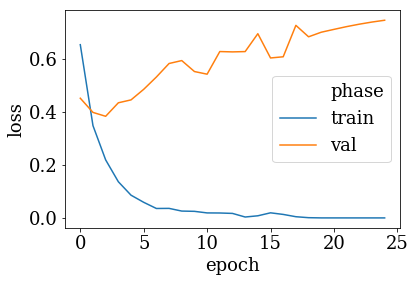

In [27]:
s = sns.lineplot(x='epoch', y='loss', data=plot_df, hue='phase')

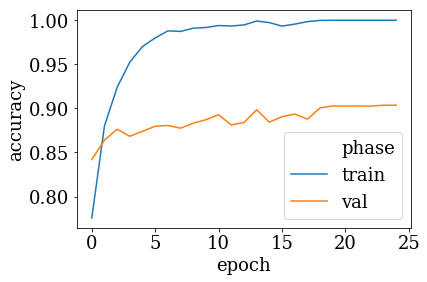

In [28]:
s = sns.lineplot(x='epoch', y='accuracy', data=plot_df, hue='phase')

In [32]:
model.eval()

Accuracy of the network on the 10000 test images: 89.38 %


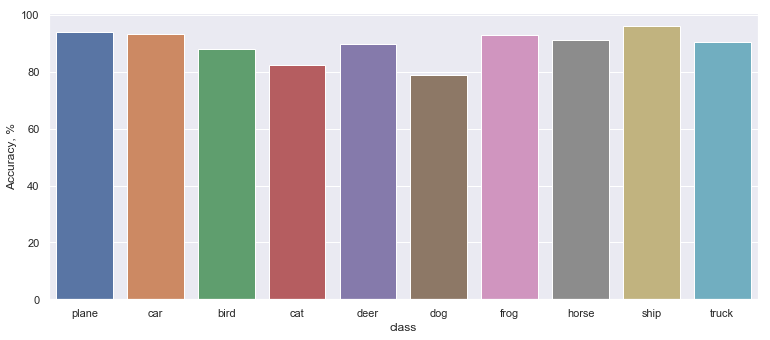

In [30]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images.to('cuda'))
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cuda') == labels.to('cuda')).sum().item()

print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = best_model(images.to('cuda'))
        _, predicted = torch.max(outputs, 1)
        c = (predicted.to('cuda') == labels.to('cuda')).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
acc_res_num = 100*np.array(class_correct) / np.array(class_total)
acc_res_df = pd.DataFrame({"class": classes, "Accuracy, %": acc_res_num})
sns.set(rc={'figure.figsize':(12.7,5.27)})
s = sns.barplot(x='class', y='Accuracy, %', data=acc_res_df)

In [31]:
acc_res = [str(round(v, 2))+"%" for v in acc_res_num]
acc_res_df_per = pd.DataFrame({"class": classes, "Accuracy, %": acc_res})
acc_res_df_per

,class,"Accuracy, %"
0,plane,94.12%
1,car,93.18%
2,bird,87.9%
3,cat,82.54%
4,deer,89.68%
5,dog,78.99%
6,frog,93.16%
7,horse,91.09%
8,ship,96.0%
9,truck,90.58%
